In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [21]:
Trials = 1
for unitary_seed in range(Trials):
    #initial_pops = [.12,.23, .36, .4, 0.1190533, .30, .25, .14]
    initial_pops = [0,0,0,0,0.5,0,0,0]
    #initial_pops = [.2,.2, .2, .2, 0.4, .2, .2, .2]
    system = DM.n_thermal_qbits(initial_pops)
    connectivity = "c6"
    unitary_energy_subspace = 1
    ordering_seed = 1
    chunk_size = 2
    order_rule_name = "mimic"
    num_steps = 1000
    data = cleo.execute(file_name="mimic",
                       connectivity=connectivity,
                       order_rule_name = order_rule_name, 
                       unitary_seed=unitary_seed,
                       unitary_energy_subspace=unitary_energy_subspace,
                       evolution_generation_type="haar2Qunitary",
                       chunk_size=chunk_size,
                       num_steps=num_steps,
                       initial_pops=initial_pops,
                       verbosity = .9)

90%
simulation complete, extracting and saving data to : ../data/mimic/mimic-8_qubits-c6_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_mimic
simulation complete, extracting and saving data to : ../data/mimic/mimic-8_qubits-c6_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_mimic
simulation complete, extracting and saving data to : ../data/mimic/mimic-8_qubits-c6_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_mimic


In [22]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/mimic")

In [23]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [24]:
newdata4 = dict(h5py.File("../data/mimic/mimic.hdf5"))

In [25]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_3_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(3)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit triplet
    #dimension 3 and 4 is the 3 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['three_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [26]:
mimic = get_pops(newdata4,8,"c6","mimic")
twoQdmsmimicC6 = get_2_qbit_dms(newdata4,8,"c6","mimic")

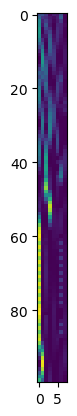

In [30]:
for i in range(1):
    plt.imshow(mimic[i][200:300], interpolation='none')
    plt.show()

In [35]:
steps=999
def tz_two_q_dyns_map(pops_trial_index): 
    tz = []
    np.array(pops_trial_index)
    for step_index in range(steps):
        tzi = pops_trial_index[step_index + 1 ] - np.cos(np.pi / 10)*np.cos(np.pi / 10)* pops_trial_index[step_index]
        tz.append(tzi)
    return tz

num_qubits = 8
def CPcond(pops) :
    list_lambda_z=[]
    CPcond=[]
    for size in range(num_qubits):
        list_lambda_z.append(np.cos(np.pi / 10) * np. cos(np.pi / 10))
    for step in tz_two_q_dyns_map(pops):
        abs_step = [abs(ele) for ele in step]
        CPcond.append(abs_step + list_lambda_z)
    return tz_two_q_dyns_map(pops)

#CPcond(popsgreedy)
def abs_tz(pops):
    abs_tz=[]
    for step in tz_two_q_dyns_map(pops):
        abs_step = [abs(ele) for ele in step]
        abs_tz.append(abs_step) 
    return abs_tz
def CPcond(abs_tz_pops) :
    cp_cond=[]
    for step in abs_tz_pops:
        cp_step = [ele + np.cos(np.pi / 10) * np. cos(np.pi / 10)  for ele in step]
        cp_cond.append(cp_step) 
    return cp_cond

In [50]:
fulllist=[]
for timestep in CPcond(abs_tz(mimic[0])):
    timesteplist=[]
    for ele in timestep:
        if ele<1:
            ele=0
        timesteplist.append(ele)
    #print(timesteplist)
    fulllist.append(timesteplist)
            
 
#plt.figure(figsize=(50, 70))
#plt.imshow(fulllist, interpolation='none')
#Add a color bar with a label
#cbar = plt.colorbar()
cbar.set_label('Relative Entropy with dynamical thermal state')
#plt.show()  


In [52]:
def moving_average(data, window_size=15):
    """
    Function to calculate the moving average of a given data array.
    
    Parameters:
    - data: The input data array.
    - window_size: The size of the moving average window.
    
    Returns:
    - moving_avg: The moving average array.
    """
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

In [63]:
def plot_one_stats_as_function_of_time(list1, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)

    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    #plt.plot(time_steps, list1, label='A')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='pink', label='Moving Average (A)')
    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
    #plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

In [60]:
def means_stds_mode_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_mode_list = []
    for step_index in range(steps):
        total = sum(pops_trial_index[step_index])
        stds = np.std(pops_trial_index[step_index])
        means = np.mean(pops_trial_index[step_index])
        mode = max(pops_trial_index[step_index])
        mean_stds_mode_list.append([total,stds,means,mode])
    return mean_stds_mode_list

def means_stds_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_list = []
    for step_index in range(steps):
        stds = np.std(pops_trial_index [step_index])
        means = np.mean(pops_trial_index[step_index])
        mean_stds_list.append([means, stds])
    return mean_stds_list
    

In [58]:
def extract_total(list_of_lists):
    return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    return [sublist[2] for sublist in list_of_lists]
def extract_mode(list_of_lists):
    return [sublist[3] for sublist in list_of_lists]

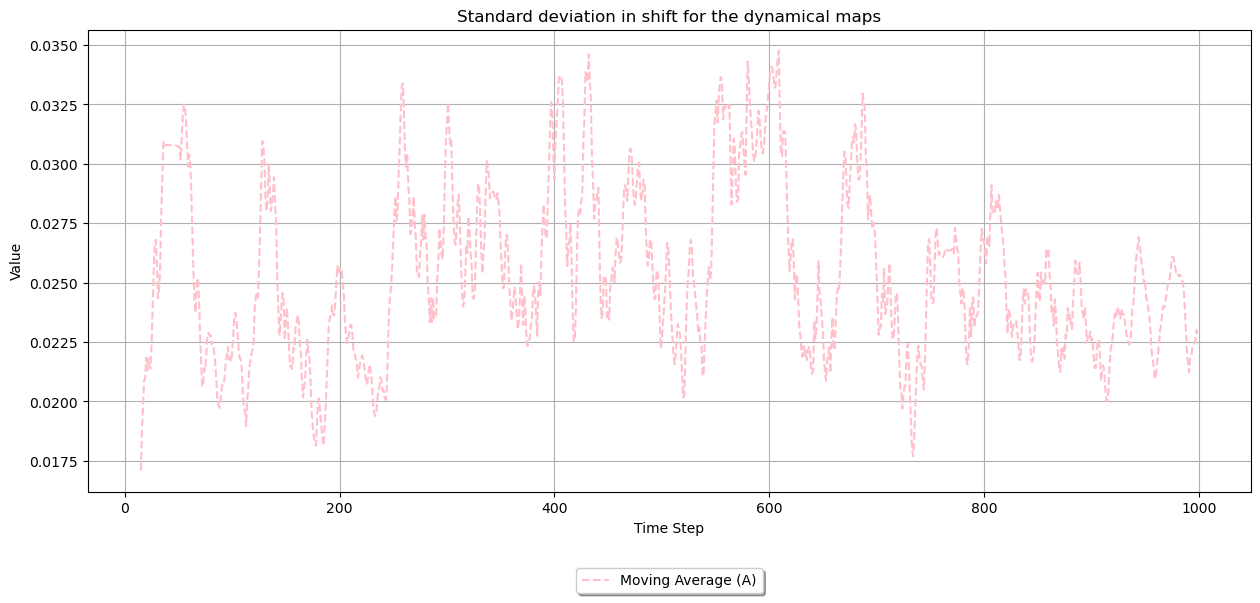

In [64]:
stds_mimicC6=extract_stds(means_stds_of_pops_of_one_sim_index(tz_two_q_dyns_map(mimic[0])))
plot_one_stats_as_function_of_time(stds_mimicC6,filename = 'tz_stds_random_greedy_landmax_temp_homo',title = 'Standard deviation in shift for the dynamical maps')
